In [ ]:
!pip install -q pycountry

In [1]:
import re #Expressões para processamento de texto
import time  #trabalhar com datas
import sqlite3 #Banco de dados SQLITE
import pycountry
import numpy as np  #manipulação de dados
import pandas as pd #manipulação de dados
import matplotlib.pyplot as plt #Vizualização de dados
import seaborn as sns #Vizualização de dados
from matplotlib import cm #'Vizualização de dados
from sklearn.feature_extraction.text import CountVectorizer #Machine learning
import warnings # Filtrar qualquer tipo de alerta, para não poluir
warnings.filterwarnings('ignore')
sns.set_theme(style = 'whitegrid') #tema para os gráficos

In [2]:
# Conexão
conn = sqlite3.connect("imdb.db")

In [3]:
# Consulta SQL para poder retornar o nome de cada tabela. (sqlite_master é uma tabela de catalogo do sqlite). A query está associada a conn (conexão)
# O comando pd.read_sql_query faz parte do pandas, ele retorna um DataFrame correspondente ao conjunto de resultados da sequência de consulta. Opcionalmente forneça um parâmetro index_col para usar uma das colunas como o índice, caso contrário, o índice inteiro padrão será usado.
tabelas = pd.read_sql_query("SELECT name AS 'Table_name' FROM sqlite_master WHERE type = 'table'", conn)

In [4]:
print(type(tabelas)) # Verificar o tipo do objeto
tabelas.head() # Dataframe com os nomes das tabelas

<class 'pandas.core.frame.DataFrame'>


,Table_name
0,people
1,titles
2,akas
3,crew
4,episodes


In [5]:
# Converter o dataframe para uma lista -
tabelas = tabelas["Table_name"].values.tolist()

In [6]:
# Percorrer a lista de tabelas no banco de dados e extrair o esquema de cada uma.
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela) # O pragma é usado para consultar informações sobre uma tabela específica. O conjunto de resultados conterá uma linha para cada coluna na tabela.table_info
    resultado = pd.read_sql_query(consulta, conn) # pd.read... é um comando que recebe como parametro a variavel 'consulta'
    print("Esquema de tabela:", tabela)
    print(resultado)
    print("-"*100)
    print("\n")

Esquema de tabela: people
   cid       name     type  notnull dflt_value  pk
0    0  person_id  VARCHAR        0       None   1
1    1       name  VARCHAR        0       None   0
2    2       born  INTEGER        0       None   0
3    3       died  INTEGER        0       None   0
----------------------------------------------------------------------------------------------------


Esquema de tabela: titles
   cid             name     type  notnull dflt_value  pk
0    0         title_id  VARCHAR        0       None   1
1    1             type  VARCHAR        0       None   0
2    2    primary_title  VARCHAR        0       None   0
3    3   original_title  VARCHAR        0       None   0
4    4         is_adult  INTEGER        0       None   0
5    5        premiered  INTEGER        0       None   0
6    6            ended  INTEGER        0       None   0
7    7  runtime_minutes  INTEGER        0       None   0
8    8           genres  VARCHAR        0       None   0
--------------------

In [7]:
# Análise exploratória de dados
# Quais as categorias de filmes mais comuns no IMDB?

# Pesquisa SQL
consulta1 = 'SELECT type, COUNT (*) AS COUNT FROM titles GROUP BY type'

In [8]:
resultado1 = pd.read_sql_query(consulta1, conn)

In [9]:
display(resultado1)

,type,COUNT
0,movie,588654
1,radioEpisode,1
2,short,832035
3,tvEpisode,6080142
4,tvMiniSeries,39843
5,tvMovie,133027
6,tvPilot,1
7,tvSeries,215328
8,tvShort,10286
9,tvSpecial,34204


In [10]:
# Calcular o percentual de cada tipo criando uma coluna. Dividir o resultado de cada linha pela somar do todo e multiplicando por 100
# Adicionar uma nova coluna é simples, bastando chamar  a variavel com os dados e adicionar ['nome da coluna']
resultado1['Percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [11]:
# Visualizando o resultado
display(resultado1)

,type,COUNT,Percentual
0,movie,588654,7.104918
1,radioEpisode,1,0.000012
2,short,832035,10.042471
3,tvEpisode,6080142,73.385916
4,tvMiniSeries,39843,0.480896
5,tvMovie,133027,1.605605
6,tvPilot,1,0.000012
7,tvSeries,215328,2.598959
8,tvShort,10286,0.124150
9,tvSpecial,34204,0.412834


In [12]:
# Retornar apenas algumas categorias, as com mais titulos e outra como uma categoria que engolba o restante

# Criar dicionário vazio
outros = {}

# Filtrar percentual em 5% do total
# Outros esta recebendo a coluna COUNT, resultado1 faz a busca na tabela nesta coluna,e uma subconsulta especifica por uma segunda busca considerando
# apenas a coluna percentual menor que 5, todo resultado que é encontrado então é somado ao final com .sum()
outros['COUNT'] = resultado1[resultado1['Percentual'] < 5 ]['COUNT'].sum()

# Gravando o resultado
outros['Percentual'] = resultado1[resultado1['Percentual'] < 5]['Percentual'].sum()

# Criando o tipo da coluna
outros['type'] = 'Outros'


In [13]:
# Vizualizar, qualquer categoria com menos de 5% entrou aqui
outros

{'COUNT': 784331, 'Percentual': 9.466694797277349, 'type': 'Outros'}

In [14]:
# Filtrar dataframe por resultado
resultado1 = resultado1[resultado1['Percentual'] > 5]

In [15]:
# Juntando o novo resultado com o resultado de Outros
resultado1 = resultado1.append(outros, ignore_index = True)

In [16]:
# Ordenar o resultado por COUNT
resultado1 = resultado1.sort_values(by = 'COUNT', ascending = False)

In [17]:
# Visualizar (Só irão aparecer 4 resultados pois acima de 5% só ha 3 tipos)
display(resultado1)

,type,COUNT,Percentual
2,tvEpisode,6080142,73.385916
1,short,832035,10.042471
3,Outros,784331,9.466695
0,movie,588654,7.104918


In [18]:
# Ajustas a tabela (listcomprehesion) Um loop com uma serie de comandos (se le de tras pra frente)
# Para cada linha do resultado esta sendo colocado o "tipo" concatenado com espaço e %
# Para o percentual ficar arredondado em vez de muitas casas decimas, a segunda parte do codigo depois da concatenação com o espaço esta arredondando round(resultado1['percentual]' em [i] para 2 casas decimais.
# O [i] que aparece em ambas as partes deste codigo é o mesmo do loop for, que é lido primeiro
labels = [str(resultado1['type'][i])+ ' ' + '[' + str(round(resultado1['Percentual'][i],2)) + '%]' for i in resultado1.index]

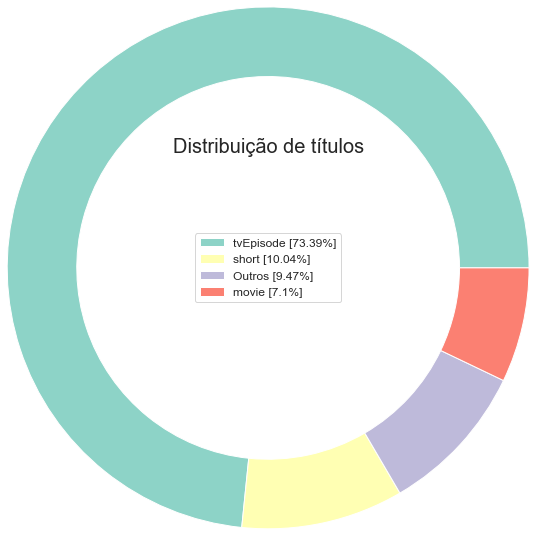

In [19]:
# Grafico
# Mapa de cores
cs = cm.Set3(np.arange(100))

# Cria figura
f = plt.figure()

# Função para criar grafico de pizza
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title('Distribuição de títulos', loc = 'Center', fontdict = {'fontsize' :20, 'fontweight' : 20})
plt.show()

In [20]:
# Qual o numero de titulos por generos? (count(*) é só uma coluna da tabela)
consulta1 = "SELECT genres, count(*) AS Quantidade FROM titles WHERE type ='movie' GROUP BY genres"

In [21]:
# Usar a query
resultado2 = pd.read_sql_query(consulta1, conn)

In [22]:
# Mostrar o resultado
display(resultado2)

,genres,Quantidade
0,Action,13434
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1442,"Thriller,Western",39
1443,War,1260
1444,"War,Western",9
1445,Western,4037


In [23]:
# Ajustar para agrupar filmes de mesmo genero e diferentes subgeneros (\N significa filmes sem genero)
# Primeiro vamos deixar todas as strings em minúsculo para facilitar a manipulação dos dados

resultado2['genres'] = resultado2['genres'].str.lower()

In [24]:
display(resultado2)

,genres,Quantidade
0,action,13434
1,"action,adult",11
2,"action,adult,adventure",1
3,"action,adult,comedy",5
4,"action,adult,crime",10
...,...,...
1442,"thriller,western",39
1443,war,1260
1444,"war,western",9
1445,western,4037


In [25]:
# Dropar valores nulos
temp = resultado2['genres'].dropna()

In [26]:
# Contar o numero de filmes para cada genero (CountVectorizer: converte coluna em um vetor e conta o numero de filmes por genero)
# O CountVectorizer irá criar uma amtriz de tokens 1 e 0 que indicaram quais filmes fazem parte do genero X ou Y ou Z..., para isso primeiro é necessário um padrão
#para buscar os dados em string

# https://docs.python.org/pt-br/3.8/library/re.html (basicamente coordenadas que serão seguidas pelo voctorizer)
padrao = '(?u)\\b[\\w-]+\\b' 

# ? Faz com que a ER resultante corresponda a 0 ou 1 repetição da ER anterior. ab? irá corresponder a ‘a’ ou ‘ab’.
# \ As sequências especiais consistem em '\' e um caractere da lista [A,a B, b,d, D, S, s, W, w, Z, z, U, u]. Se o caractere comum não for um dígito ASCII ou uma letra ASCII, a ER resultante corresponderá ao segundo caractere. Por exemplo, \$ corresponde ao caractere '$'
# \b Corresponde à string vazia, mas apenas no início ou no final de uma palavra. Uma palavra é definida como uma sequência de caracteres de palavras. Observe que, formalmente, \b é definido como a fronteira entre um caractere \w e um \W (ou vice-versa), ou entre \w e o início/fim da string. 
# \w Para padrões (str) Unicode: Corresponde a caracteres de palavras Unicode; isso inclui a maioria dos caracteres que podem fazer parte de uma palavra em qualquer idioma, bem como números e sublinhado. Se o sinalizador ASCII for usado, apenas [a-zA-Z0-9_] será correspondido.
# + Faz com que a ER resultante corresponda a 1 ou mais repetições da ER anterior. ab+ irá corresponder a ‘a’ seguido por qualquer número diferente de zero de ‘b’s; não corresponderá apenas a ‘a’.
# - Se - for escapado (por exemplo, [a\-z]) ou se for colocado como o primeiro ou último caractere (por exemplo, [-a] ou [a-]), ele corresponderá a um literal '-'



# o .fit() treina o vetor
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [27]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [28]:
# Aplicar a vetorização dos dados sem valores NA
bag_genres = vetor.transform(temp)

In [29]:
type(bag_genres)

scipy.sparse.csr.csr_matrix

In [30]:
# A partir do vetor obter o nome dos atributos
generos_unicos = vetor.get_feature_names()

In [31]:
# Criar o dataframe de generos, precisamos converter para uma tabela para ficar mais facil de manipular
generos = pd.DataFrame(bag_genres.todense(), columns = generos_unicos, index = temp.index)

In [32]:
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1447 entries, 0 to 1446
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1447 non-null   int64
 1   adult        1447 non-null   int64
 2   adventure    1447 non-null   int64
 3   animation    1447 non-null   int64
 4   biography    1447 non-null   int64
 5   comedy       1447 non-null   int64
 6   crime        1447 non-null   int64
 7   documentary  1447 non-null   int64
 8   drama        1447 non-null   int64
 9   family       1447 non-null   int64
 10  fantasy      1447 non-null   int64
 11  film-noir    1447 non-null   int64
 12  game-show    1447 non-null   int64
 13  history      1447 non-null   int64
 14  horror       1447 non-null   int64
 15  music        1447 non-null   int64
 16  musical      1447 non-null   int64
 17  mystery      1447 non-null   int64
 18  n            1447 non-null   int64
 19  news         1447 non-null   int64
 20  reality-

In [33]:
# Retirar a coluna "N"
generos = generos.drop(columns = 'n', axis = 0)

In [34]:
# Transformar o resultado em percentual

percentual = 100 * pd.Series(generos.sum(0)).sort_values(ascending = False) / generos.shape[0]

In [35]:
percentual.head(28)

drama          18.382861
comedy         16.931583
documentary    15.964064
adventure      14.858328
action         14.581894
romance        13.476158
crime          13.061507
mystery        12.577747
thriller       12.370422
fantasy        12.232205
horror         11.817554
history        11.748445
animation      11.195577
music          11.057360
family         11.057360
biography      10.642709
sci-fi         10.642709
musical        10.435384
war             8.984105
western         8.845888
sport           8.154803
adult           6.150657
news            3.593642
reality-tv      2.971666
film-noir       2.349689
short           1.727713
talk-show       0.967519
game-show       0.483760
dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

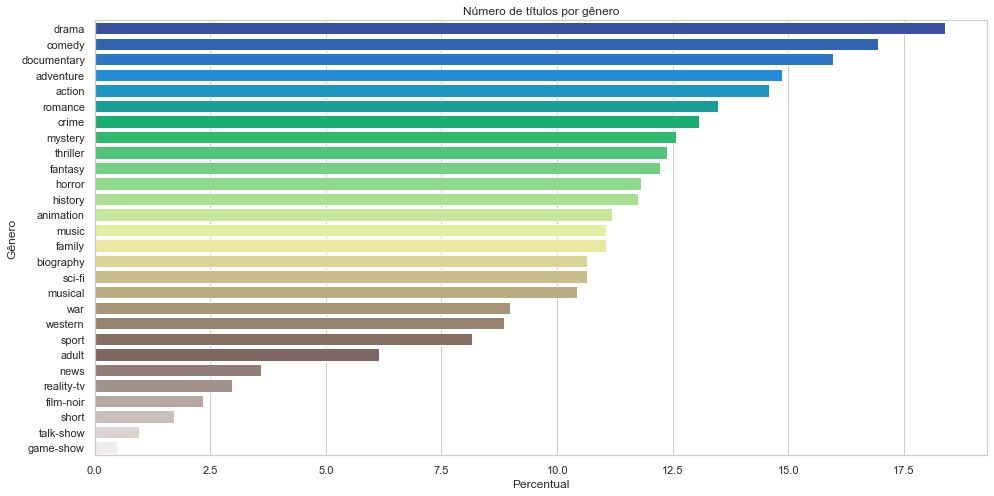

In [36]:
# Criando uma figura

plt.figure(figsize = (16,8))
sns.barplot(x = percentual.values, y = percentual.index, orient = 'h', palette = 'terrain') #SNS é o seaborn
plt.ylabel('Gênero')
plt.xlabel('Percentual')
plt.title('Número de títulos por gênero')
plt.show

In [37]:
# QUAL a mediana de filmes por genero? (valor do meio de uma distribuição, pois a mediapode ser afetada por valores extremos)

consulta3 = "SELECT rating, genres FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE premiered <= 2022 AND type = 'movie'"

In [38]:
resultado3 = pd.read_sql_query(consulta3, conn)

In [39]:
display(resultado3)

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
268778,3.6,"Action,Adventure,Thriller"
268779,5.8,Thriller
268780,6.4,"Drama,History"
268781,3.8,"Adventure,History,War"


In [40]:
# Precisaremos trazer os generos separados novamente, como no exemplo anterior

def retorna_generos(df):
    df['genres'] = df['genres'].str.lower()
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [41]:
# Aplicar a função
generos_unicos1 = retorna_generos(resultado3)

In [42]:
generos_unicos1

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [43]:
# Criando listas para contar filmes por genero e avaliações
genero_count = []
genero_ratings = []

In [44]:
# Buscar os dados via linguagem SQL para cada titulo
# Loop
for item in generos_unicos:
    
    #Retornar a contagem de filmes por genero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '+ '\''+'%' +item+'%'+'\' AND type = \'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado.values[0][0])
    
    #Retornar avaliação de filmes por genero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '+ '\''+'%' +item+'%'+'\' AND type = \'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating'])) #Aqui encontramos a mediana em rating

In [45]:
# Dataframe final

df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_count
df_genero_ratings['rating'] = genero_ratings

In [46]:
df_genero_ratings.head(20)

,genres,count,rating
0,action,28826,5.8
1,adult,4086,5.8
2,adventure,17628,6.0
3,animation,4693,6.5
4,biography,8091,7.0
5,comedy,66928,6.0
6,crime,23127,6.1
7,documentary,39469,7.3
8,drama,119328,6.3
9,family,10183,6.3


In [47]:
# Remover um genero
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [48]:
df_genero_ratings.head(20)

,genres,count,rating
0,action,28826,5.8
1,adult,4086,5.8
2,adventure,17628,6.0
3,animation,4693,6.5
4,biography,8091,7.0
5,comedy,66928,6.0
6,crime,23127,6.1
7,documentary,39469,7.3
8,drama,119328,6.3
9,family,10183,6.3


In [49]:
# Reordenar a lista que esta sem o 18
df_genero_ratings = df_genero_ratings.sort_values(by ='rating', ascending = False)

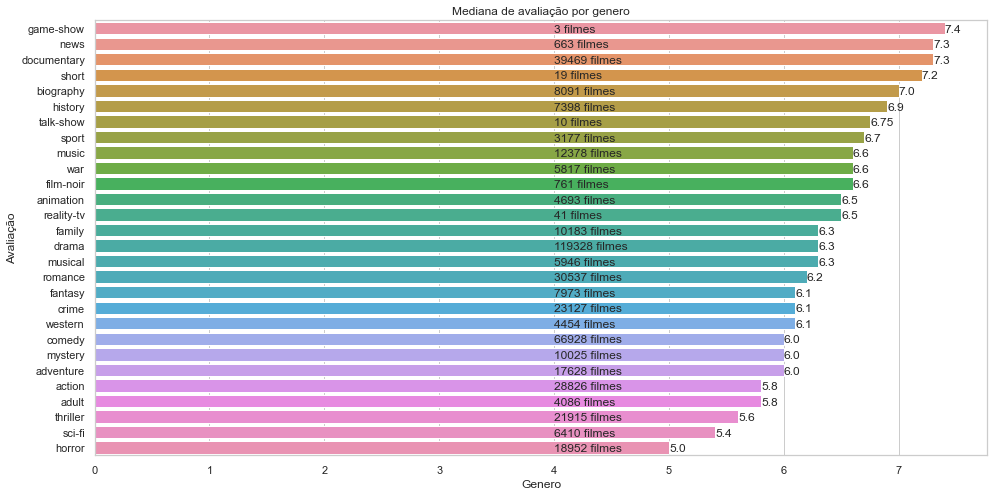

In [50]:
plt.figure(figsize = (16,8))
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = 'h')

#Texto do gráfico
for i in range(len(df_genero_ratings.index)):
    plt.text(4.0, i + 0.25, str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]], i + 0.25, round(df_genero_ratings['rating'][df_genero_ratings.index[i]],2))
    
plt.xlabel('Genero')
plt.ylabel('Avaliação')
plt.title('Mediana de avaliação por genero')
plt.show()

In [51]:
# Qual a mediana de avaliação dos filmes por ano de estreia?

consulta4 = "SELECT rating AS Rating, premiered FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE premiered <= 2022 AND type = 'movie' ORDER BY premiered"

In [52]:
resultado4 = pd.read_sql_query(consulta4, conn)

In [53]:
display(resultado4)

,Rating,premiered
0,6.4,1896
1,4.4,1897
2,3.9,1899
3,3.7,1899
4,6.0,1900
...,...,...
268778,4.8,2021
268779,9.1,2021
268780,5.0,2021
268781,5.9,2021


In [54]:
# Agrupar todos os anos repetidos
rating = []

# Lopp, para cada ano (considera todos os repetidos) dentro da lista de ano de estreia vai ser calculada a mediana para o ano
for year in set(resultado4['premiered']):
    rating.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [55]:
# Listando 10 elementos
rating[1:10]

[4.4, 3.8, 5.9, 4.6, 3.5, 4.6, 5.4, 4.5, 3.6]

In [56]:
anos = list(set(resultado4['premiered']))

In [57]:
anos[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

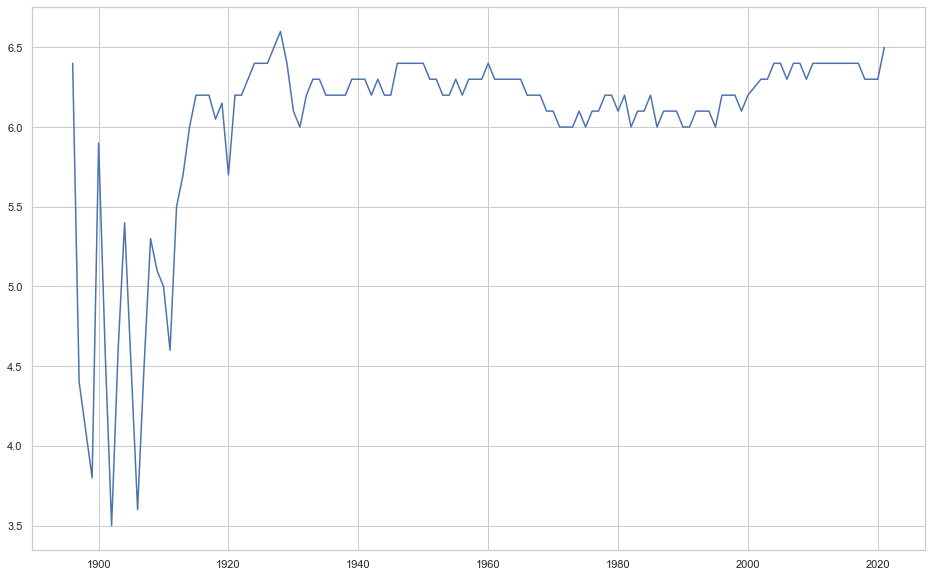

In [58]:
plt.figure(figsize = (16,10))
plt.plot(anos, rating)
plt.show()

# A anomalia inicial do grafico se da por menos filmes terem estreado em 1900 e poucas pessoas avaliaram, então houveram poucos numeros que causam discrepancias grandes

In [59]:
# Qual o numero de filmes avaliados por genero em relação ao ano de estreia (TOP 5)
consulta5 = 'SELECT genres FROM titles'

In [60]:
resultado = pd.read_sql_query(consulta5, conn)

In [61]:
display(resultado)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8285157,"Action,Drama,Family"
8285158,"Action,Drama,Family"
8285159,"Action,Drama,Family"
8285160,Short


In [62]:
# Função que criamos anteriormente para unificar subgeneros de um genero
generos_unicos = retorna_generos(resultado)

In [63]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [64]:
# Contagem
genero_count1 = []
for i in generos_unicos:
    consulta = 'Select COUNT(*) AS COUNT FROM titles WHERE genres LIKE '+ '\''+'%' +item+'%'+'\' AND type = \'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count1.append(resultado['COUNT'].values[0])

In [65]:
# Preparar o dataframe

df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count1

In [66]:
# Calcular o top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending =  False)
top_generos = df_genero_count.head()['genre'].values

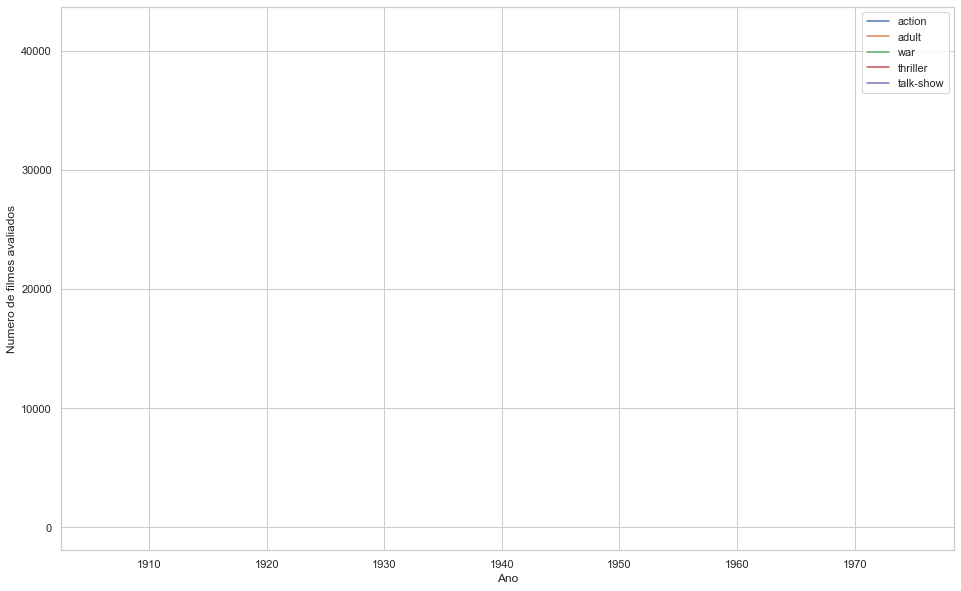

In [68]:
# Plot

plt.figure(figsize = (16,10))

# Loop para por texto em cada barra
for item in top_generos:
    consulta = 'SELECT COUNT(*), premiered FROM titles WHERE genres LIKE '+ '\''+'%' +item+'%'+'\' AND type = \'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['premiered'], resultado['COUNT(*)'])

    
plt.xlabel('Ano')
plt.ylabel('Numero de filmes avaliados')
plt.legend(labels = top_generos)
plt.show()

# O grafico ficou sem dados !?

In [ ]:
# QUal filme com maior tempo de duração? Calcule o percentil

In [72]:
# Criando a consulta
# Procurando dados na coluna runtime_minutes da tabela titles onde a coluna type é filme e o tempo (runtime) seja diferente de NaN (SEM TEMPO ESTIPULADO)
consulta6 = "SELECT runtime_minutes AS Runtime FROM titles WHERE type = 'movie' AND Runtime != 'NaN'"


In [73]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [74]:
display(resultado6)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
370470,123
370471,57
370472,100
370473,116


In [97]:
# Loop para calcular o percentil (usando pacote np)
# O percentil divide os dados em 100 partes iguais (101 no range pq zero é contado)
# O resultado indica que por exemplo, no percentil 1 houve um filme que durou 45 minutos e no percentil 100 um que durou mais de 5 mil minutos (está certo?)
# No percentil 50 vemos a mediana que corresponde a 89 minutos

#Para o grafico
percentil = []
duracao = []

for i in range(101): 
    perc = round(np.percentile(resultado6['Runtime'], i), 2) 
    print(f'{i} percentil de duração é: {perc}')
    percentil.append(i)
    duracao.append(perc)

0 percentil de duração é: 1.0
1 percentil de duração é: 45.0
2 percentil de duração é: 48.0
3 percentil de duração é: 50.0
4 percentil de duração é: 50.0
5 percentil de duração é: 52.0
6 percentil de duração é: 52.0
7 percentil de duração é: 54.0
8 percentil de duração é: 55.0
9 percentil de duração é: 56.0
10 percentil de duração é: 58.0
11 percentil de duração é: 59.0
12 percentil de duração é: 60.0
13 percentil de duração é: 60.0
14 percentil de duração é: 60.0
15 percentil de duração é: 62.0
16 percentil de duração é: 63.0
17 percentil de duração é: 65.0
18 percentil de duração é: 66.0
19 percentil de duração é: 68.0
20 percentil de duração é: 70.0
21 percentil de duração é: 70.0
22 percentil de duração é: 71.0
23 percentil de duração é: 72.0
24 percentil de duração é: 73.0
25 percentil de duração é: 74.0
26 percentil de duração é: 75.0
27 percentil de duração é: 75.0
28 percentil de duração é: 76.0
29 percentil de duração é: 77.0
30 percentil de duração é: 78.0
31 percentil de dur

In [84]:
# Vemos que houve um outlier no resutlado anterior, então devemos especionar se realmente é um dado errado, para isso, vamos fazer uma consulta simples para acha-lo

consulta7 = "SELECT runtime_minutes, primary_title FROM titles WHERE type ='movie' AND Runtime_minutes != 'NaN' ORDER BY Runtime_minutes DESC"

# Caso queira limitar a tabela que será mostrada posso adicionar após o DESC (decrescente) o comando sql LIMIT e um numero de linhas para serme mostradas (LIMIT 1)

In [85]:
resultado7 = pd.read_sql_query(consulta7, conn)

In [86]:
# lOGISTIC DE fato é um filme com essa duração, nesse caso não houve outlier

display(resultado7)

,runtime_minutes,primary_title
0,51420,Logistics
1,43200,Ambiancé
2,28643,Carnets Filmés (Liste Complète)
3,14400,Modern Times Forever
4,10062,Qw
...,...,...
370470,1,Communist Shrek
370471,1,Corona Extra TV Commercial Featuring Jon Gruden
370472,1,The Fly
370473,1,2036


In [103]:
# Retirando o Logistics para tentar fazer um grafico e limitando filmes de ate 400 min
consulta8 = "SELECT runtime_minutes, primary_title FROM titles WHERE type ='movie' AND runtime_minutes != 'NaN' AND runtime_minutes <= 400 ORDER BY Runtime_minutes DESC"

In [104]:
resultado8 = pd.read_sql_query(consulta8, conn)

In [109]:
# Percentil novamente ( O i dentro do np.percentile(, i) é necessário para que o metodo coloque aquele valor naquele percentil)

percentil1 = []
duracao1 = []

for i in range(101):
    perc1 = round(np.percentile(resultado8['runtime_minutes'], i), 2)
    print(f'O percentil é {i}, com duração {perc1}')
    percentil1.append(i)
    duracao1.append(perc1)

O percentil é 0, com duração 1.0
O percentil é 1, com duração 45.0
O percentil é 2, com duração 48.0
O percentil é 3, com duração 50.0
O percentil é 4, com duração 50.0
O percentil é 5, com duração 52.0
O percentil é 6, com duração 52.0
O percentil é 7, com duração 54.0
O percentil é 8, com duração 55.0
O percentil é 9, com duração 56.0
O percentil é 10, com duração 58.0
O percentil é 11, com duração 59.0
O percentil é 12, com duração 60.0
O percentil é 13, com duração 60.0
O percentil é 14, com duração 60.0
O percentil é 15, com duração 62.0
O percentil é 16, com duração 63.0
O percentil é 17, com duração 65.0
O percentil é 18, com duração 66.0
O percentil é 19, com duração 68.0
O percentil é 20, com duração 70.0
O percentil é 21, com duração 70.0
O percentil é 22, com duração 71.0
O percentil é 23, com duração 72.0
O percentil é 24, com duração 73.0
O percentil é 25, com duração 74.0
O percentil é 26, com duração 75.0
O percentil é 27, com duração 75.0
O percentil é 28, com duração 7

{'whiskers': [<matplotlib.lines.Line2D at 0x223002c8790>,
 'caps': [<matplotlib.lines.Line2D at 0x223002c8e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x223002c8430>],
 'medians': [<matplotlib.lines.Line2D at 0x223002d1550>],
 'fliers': [<matplotlib.lines.Line2D at 0x223002d18b0>],
 'means': []}

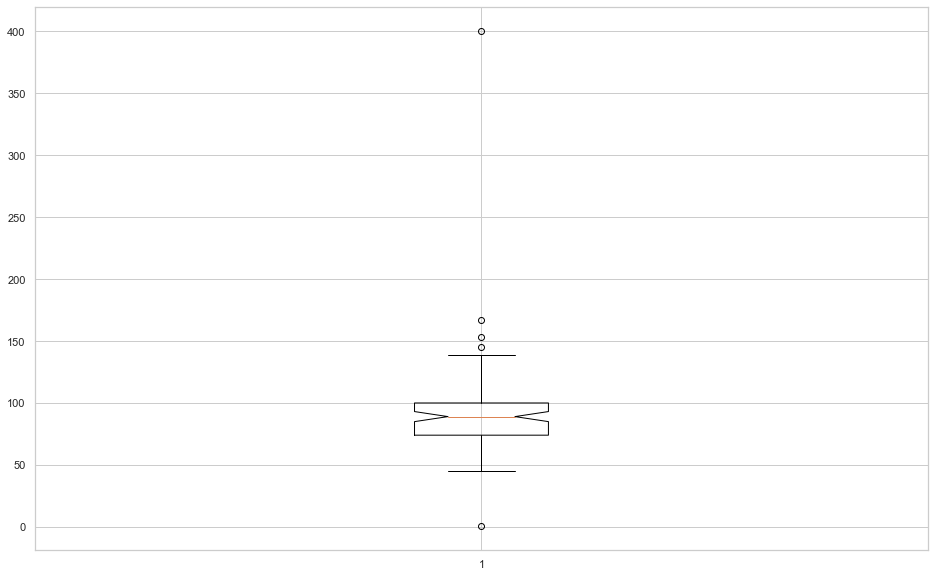

In [112]:
# A figura vai mostras outlier (pontos) e os quartis onde se encontram a maioria dos filmes, a mediana 89 (onde ficaria o percentil 50)
plt.figure(figsize = (16,10))

plt.boxplot(duracao1, percentil1)

In [116]:
# Qual a relação entre a duração do filme e o genero? Usar comando AVG do SQL

consulta9 = "SELECT AVG(runtime_minutes), genres FROM titles WHERE type = 'movie' AND runtime_minutes != 'NaN' GROUP BY genres"

In [117]:
resultado9 = pd.read_sql_query(consulta9, conn)

In [118]:
display(resultado9)

,AVG(runtime_minutes),genres
0,99.336592,Action
1,77.000000,"Action,Adult"
2,69.000000,"Action,Adult,Adventure"
3,74.000000,"Action,Adult,Comedy"
4,84.666667,"Action,Adult,Crime"
...,...,...
1359,93.928571,"Thriller,Western"
1360,93.313356,War
1361,98.000000,"War,Western"
1362,72.312947,Western


In [119]:
# Vamos unificar os generos novamente
generos_unicos2 = retorna_generos(resultado9)


In [120]:
generos_unicos2

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [137]:
genero_runtime = []

for i in generos_unicos2:
    consulta9 = 'SELECT runtime_minutes FROM titles WHERE genres LIKE '+ '\''+'%' +i+'%'+'\' AND type = \'movie\' AND runtime_minutes != \'NaN\''
    resultado9 = pd.read_sql_query(consulta9, conn)
    genero_runtime.append(np.median(resultado9['runtime_minutes']))

In [138]:
# Criar o dataframe

df_generos_runtime = pd.DataFrame()
df_generos_runtime['genres'] = generos_unicos2
df_generos_runtime['runtime_minutes'] = genero_runtime

In [139]:
df_generos_runtime.head()

,genres,runtime_minutes
0,action,93.0
1,adult,77.0
2,adventure,90.0
3,animation,82.0
4,biography,87.0


In [140]:
# Ordenas os valores deste dataframe pelo runtime

df_generos_runtime = df_generos_runtime.sort_values(by = 'runtime_minutes', ascending = False)

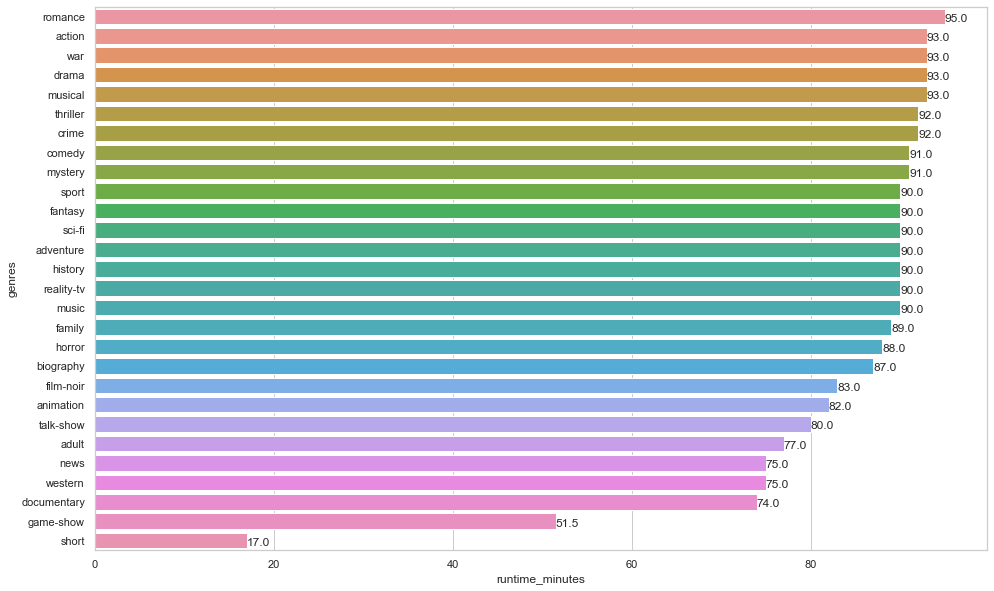

In [150]:
plt.figure(figsize = (16, 10))

sns.barplot(y = df_generos_runtime.genres, x = df_generos_runtime.runtime_minutes, orient = 'h')


for i in range(len(df_generos_runtime.index)):
    plt.text(df_generos_runtime.runtime_minutes[df_generos_runtime.index[i]], i + 0.25, round(df_generos_runtime['runtime_minutes'][df_generos_runtime.index[i]], 2))




In [154]:
# Filmes por região

consulta10 = "SELECT region, COUNT(*) FROM akas JOIN titles ON akas.title_id = titles.title_id WHERE region != 'None' AND type = 'movie' GROUP BY region"

In [155]:
resultado10 = pd.read_sql_query(consulta10, conn)

In [156]:
display(resultado10)

,region,COUNT(*)
0,AD,22
1,AE,707
2,AF,110
3,AG,12
4,AL,1235
...,...,...
229,YUCS,146
230,ZA,3052
231,ZM,11
232,ZRCD,2


In [157]:
# Esse comando me permite ver o numero de linhas [0], colunas[1]
resultado10.shape 

(234, 2)

In [159]:
# Precisamos converter as siglas das regiões para numero de países
nome_paises = []
numerodefilmes = []

for i in range(resultado10.shape[0]):
    try:
        coun = resultado10['region'].values[i]
        nome_paises.append(pycountry.countries.get(alpha_2 = coun).name) #Este codigo usa o pacote pycountry para traduzir a sigla pra nome de país, usa a variavel coun que deifnimos acima
        numerodefilmes.append(resultado10['COUNT(*)'].values[i])
    except:
        continue


In [161]:
df_paises = pd.DataFrame()
df_paises['Países'] = nome_paises
df_paises['Quantidade'] = numerodefilmes

In [162]:
# Ordenar

df_paises = df_paises.sort_values(by = 'Quantidade', ascending = False)

In [164]:
df_paises.head(10)

,Países,Quantidade
199,United States,297718
65,United Kingdom,152996
96,Japan,89064
63,France,81933
89,India,74701
32,Canada,70960
47,Germany,67505
93,Italy,63794
26,Brazil,62934
58,Spain,62516


In [174]:
# Quais os TOP10 melhores e piores filmes? Apenas com SQL

consulta11 = "SELECT primary_title AS Nome_do_Filme, genres AS Genero, rating AS Avaliacao FROM titles JOIN ratings WHERE titles.title_id = ratings.title_id AND titles.type = 'movie' AND ratings.votes >= 25000 ORDER BY rating DESC LIMIT 10"

In [175]:
resultado11 = pd.read_sql_query(consulta11, conn)

In [176]:
display(resultado11)

,Nome_do_Filme,Genero,Avaliacao
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,Soorarai Pottru,Drama,9.1
4,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
5,12 Angry Men,"Crime,Drama",9.0
6,The Godfather: Part II,"Crime,Drama",9.0
7,The Dark Knight,"Action,Crime,Drama",9.0
8,David Attenborough: A Life on Our Planet,"Biography,Documentary",9.0
9,Schindler's List,"Biography,Drama,History",8.9


In [177]:
# Quais os TOP10 piores filmes? Apenas com SQL (mudou apenas o DESC colcoando o ASC, ou seja do menor para o maior)

consulta12 = "SELECT primary_title AS Nome_do_Filme, genres AS Genero, rating AS Avaliacao FROM titles JOIN ratings WHERE titles.title_id = ratings.title_id AND titles.type = 'movie' AND ratings.votes >= 25000 ORDER BY rating ASC LIMIT 10"

In [178]:
resultado12 = pd.read_sql_query(consulta12, conn)

In [179]:
display(resultado12)

,Nome_do_Filme,Genero,Avaliacao
0,Cumali Ceber,Comedy,1.0
1,Smolensk,"Drama,Thriller",1.1
2,Sadak 2,"Action,Drama",1.1
3,Reis,"Biography,Drama",1.4
4,Justin Bieber: Never Say Never,"Documentary,Music",1.6
5,Manos: The Hands of Fate,"Drama,Horror",1.8
6,Radhe,"Action,Crime,Thriller",1.8
7,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
8,The Hottie & the Nottie,"Comedy,Romance",1.9
9,Disaster Movie,"Comedy,Sci-Fi",1.9
